# Decoding Coordinates from the City Database

We load some coordinates of known places:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/coords.tsv", sep='\t')
df

,place,scr_e,scr_n,db_i_e,db_i_n,db_f_e,db_f_n,OSM_lat,OSM_lon,utm_e,utm_n,utm_zone,gkk_e,gkk_n,5671_e,5671_n
0,Salzf,4507053,5729263,2488688,5629157,720056.44,5739412.0,51.69384,12.17501,304760.94,5730765.42,33U,4512205,5728851,4512101,5729393
1,Zörbig,4503018,5721808,2481021,5627271,716222.94,5731870.0,51.62776,12.11612,300401.46,5723577.59,33U,4508145,5721491,4508040,5722033
2,Halle,4490517,5705596,2456868,5623144,704146.00,5715363.0,51.48418,11.93389,703699.92,5707752.03,32U,4495512,5705512,4495407,5706054
3,Wismar,4611018,5935531,2685458,5681318,818441.00,5948058.0,53.52240,13.79450,420080.04,5931061.87,33U,4619115,5933817,4619014,5934361
4,Kassel,4320252,5687476,2116909,5617475,534166.69,5692685.0,51.31408,9.48826,534029.09,5684865.90,32U,4324992,5689580,4324884,5690124
5,Emden,4173357,5921224,1522226,5674711,380556.66,5921630.5,53.36584,7.20555,380599.80,5914469.08,32U,4181051,5925611,4180943,5926161


The columns explained:
| column | explanation |
|:-------|:------------|
| place | name of the city |
| scr_e / scr_n | easting/northing of screen coordinates (manually read from below mouse pointer) |
| db_i_e / db_i_n | easting/northing of database coordinates (as 32 bit unsigned integers) |
| db_f_e / db_f_n | easting/northing of database coordinates (as 64 bit floats (actually: double)) |
| OSM_lat / OSM_lon | latitude/longitude from OpenStreetMap (manually compared to city sign position) |
| utm_e / utm_n | easting/northing in UTM/WGS84 derived from OSM_lat / OSM_lon |
| gkk_e / gkk_n | easting/northing in GKK derived from OSM_lat / OSM_lon |

Let us plot some of these coordinates:

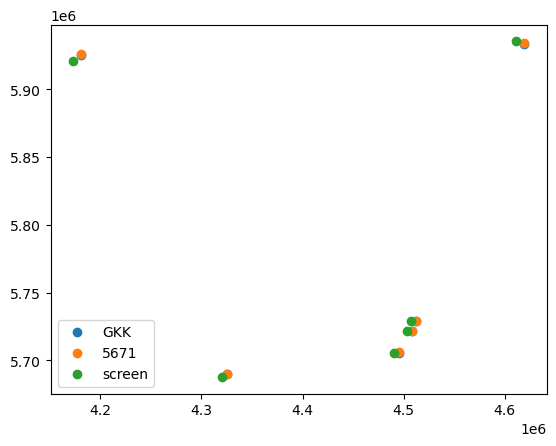

In [4]:
plt.plot(df["gkk_e"], df["gkk_n"], 'o', label="GKK")
plt.plot(df["5671_e"], df["5671_n"], 'o', label="5671")
plt.plot(df["scr_e"], df["scr_n"], 'o', label="screen")
plt.legend()
plt.show()

In [5]:
df["5671_e"] - df["scr_e"]

0    5048
1    5022
2    4890
3    7996
4    4632
5    7586
dtype: int64

My idea now is to take the "well-formed" coordinates (e.g., from OSM), transform them using all projections available in osgeo and then compute the difference between the result and the screen coordinates from D-Sat. Ideally, we the "true" projection can be found as the one with the smallest distance.

errors: 5233
deltas: 6563


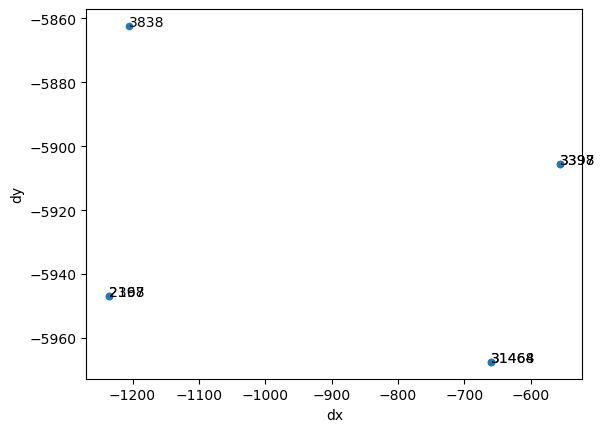

In [13]:
from osgeo import ogr
from osgeo import osr
import sqlite3

import contextlib
import os
# redired stderr to dev null
devnull = open(os.devnull, 'w')
contextlib.redirect_stderr(devnull)


def transform(src, trg, coords):
    """Transform coords from src projection to trg projection."""
    source = osr.SpatialReference()
    source.ImportFromEPSG(src)
    target = osr.SpatialReference()
    target.ImportFromEPSG(trg)

    transform = osr.CoordinateTransformation(source, target)

    trans_coords = []
    for i, coord in coords.iterrows():
        c = coord.tolist()
        point = ogr.CreateGeometryFromWkt("POINT (" + str(c[0]) + " " + str(c[1]) + ")")
        point.Transform(transform)
        p = point.GetPoint()
        trans_coords.append([int(p[0]), int(p[1])])
    return pd.DataFrame(trans_coords, columns=["n", "e"])


def diff(src, trg, src_coords, trg_coords):
    """Transform src_coords from src projection to trg projection and compute difference to trg_coords."""
    src_coords_trans = transform(src, trg, src_coords)
    delta_x = trg_coords.iloc[:, 0] - src_coords_trans.iloc[:, 0]
    delta_y = trg_coords.iloc[:, 1] - src_coords_trans.iloc[:, 1]
    
    return pd.DataFrame({"dx" : delta_x, "dy" : delta_y})


# get all projection IDs from proj database
con = sqlite3.connect("/usr/share/proj/proj.db")
codes = pd.read_sql_query("SELECT code FROM geodetic_crs UNION SELECT code FROM projected_crs", con)

deltas = []
errors = []
#for epsg in [3838, 4179, 4284, 5671, 31468]:
#for epsg in [3838, 31468]:
for epsg in codes["code"].tolist():
    try:
        delta = diff(4326, epsg, df[["OSM_lat", "OSM_lon"]], df[["scr_n", "scr_e"]])
        deltas.append([epsg, delta.dx.mean(), delta.dy.mean()])
    except:
        errors.append(epsg)
    
deltas = pd.DataFrame(deltas, columns=["epsg", "dx", "dy"])

print("errors:", len(errors))
print("deltas:", len(deltas))

# filter projections with "small" differences (Δlat < 10km and Δlon < 10km)
deltas_filtered = deltas.loc[(deltas.dx.abs() < 10000) & (deltas.dy.abs() < 10000)]

# plot coordinates for filtered propjections
fig, ax = plt.subplots()
deltas_filtered.plot("dx", "dy", kind="scatter", ax=ax)
for k, v in deltas_filtered.iterrows():
    ax.annotate(int(v["epsg"]), v[["dx", "dy"]])
plt.show()